In [133]:
import cv2
import dlib
import os
import numpy as np
import imutils
from imutils import face_utils

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split

import os
import pandas as pd

os.environ["OPENCV_OPENCL_RUNTIME"] = "disabled"

In [88]:
# save the images
def save_image(image, output_dir, filename):
    os.makedirs(output_dir, exist_ok=True)
    cv2.imwrite(os.path.join(output_dir, filename), image)

# resize 
def resize_image(image, width=640, height=640):
    return cv2.resize(image, (width, height))

In [90]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# face landmark
predictor_path = "shape_predictor_68_face_landmarks.dat" 
predictor = dlib.shape_predictor(predictor_path)

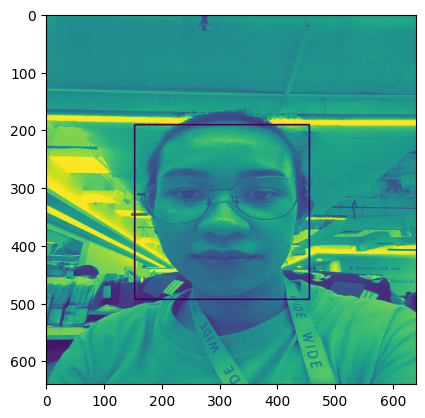

In [124]:
image_path = os.path.join("Dataset/raw/Neutral/new_real-36-_jpg.rf.8dd2f3284638a5aaadbd5a9629777d1c.jpg")
image = cv2.imread(image_path)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

for (x, y, w, h) in faces:
    cv2.rectangle(gray, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
imgplot = plt.imshow(gray)
plt.show()

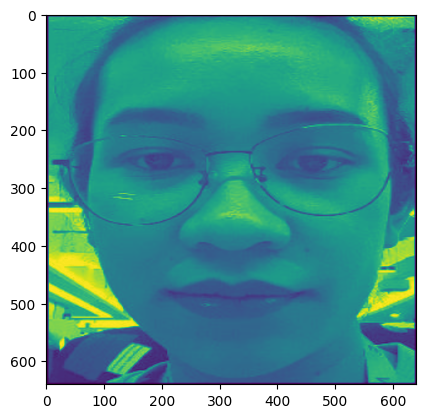

In [125]:
x, y, w, h = faces[0]
crop_img = gray[y:y+h, x:x+w]

crop_img = resize_image(crop_img)

imgplot = plt.imshow(crop_img)
plt.show()

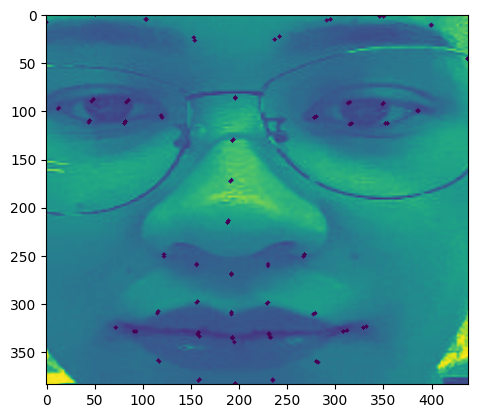

In [127]:
facial_landmarks = []
for (x, y, w, h) in faces:
    h , w = crop_img.shape
    face_rect = dlib.rectangle(0, 0, 0 + w, 0 + h)
    landmarks = predictor(crop_img, face_rect)
    landmarks = face_utils.shape_to_np(landmarks)
    facial_landmarks.append(landmarks)

    feature_indices = list(range(18, 68))
    feature_points = np.array([(landmarks[i][0], landmarks[i][1]) for i in feature_indices])

    for (x, y) in feature_points:
        cv2.circle(crop_img, (x, y), 2, (0, 255, 0), -1)

x, y, w, h = cv2.boundingRect(feature_points)
crop_img = crop_img[y:y + h, x:x + w]

imgplot = plt.imshow(crop_img)
plt.show()

In [144]:
input_dir = "Dataset/raw/Neutral"
face_extract_dir = "Dataset/preproses/face_extract/Neutral"
feat_extract_dir = "Dataset/preproses/feature_extract/Neutral"

for filename in os.listdir(input_dir):
    image_path = os.path.join(input_dir, filename)
    image = cv2.imread(image_path)

    # Detect faces and extract facial landmarks
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
    #facial_landmarks = detect_faces_and_landmarks(image)

    if len(faces) == 1:  # Only process images with exactly one face detected
        # Crop feature region
        x, y, w, h = faces[0]
        crop_img = gray[y:y+h, x:x+w]
        crop_img = resize_image(crop_img)
        save_image(crop_img, face_extract_dir, filename)
        
        facial_landmarks = []
        for (x, y, w, h) in faces:
            h , w = crop_img.shape
            face_rect = dlib.rectangle(0, 0, 0 + w, 0 + h)
            landmarks = predictor(crop_img, face_rect)
            landmarks = face_utils.shape_to_np(landmarks)
            facial_landmarks.append(landmarks)

            feature_indices = list(range(18, 68))
            feature_points = np.array([(landmarks[i][0], landmarks[i][1]) for i in feature_indices])

            # for (x, y) in feature_points:
            #     cv2.circle(crop_img, (x, y), 2, (0, 255, 0), -1)

        x, y, w, h = cv2.boundingRect(feature_points)
        crop_img = crop_img[y:y + h, x:x + w]
        crop_img = resize_image(crop_img, 64, 64)
        
        save_image(crop_img, feat_extract_dir, filename)
    else:
        print(f"Image '{filename}' does not contain exactly one face. Skipping...")


Image 'Training_99746769_jpg.rf.a17e4c188dfc84f3d2f56d5be4117c8b.jpg' does not contain exactly one face. Skipping...
Image 'Training_99760416_jpg.rf.d7f03ed5b426631db3fffe6103af929c.jpg' does not contain exactly one face. Skipping...
Image 'Training_99766691_jpg.rf.3e7159b1570ed2e9f39ab309791148f7.jpg' does not contain exactly one face. Skipping...
Image 'Training_99840794_jpg.rf.d670a14c2924c10b72810e58448ee708.jpg' does not contain exactly one face. Skipping...
Image 'Training_99862686_jpg.rf.5a6f69d2f7bbeaf0b09cc0a9e25fa421.jpg' does not contain exactly one face. Skipping...
Image 'Training_99878127_jpg.rf.a1c444b0ebaf97ab82b502fb6c9af23e.jpg' does not contain exactly one face. Skipping...
Image '0-1163-_jpg.rf.4cb22b62012e63d7c0a5c0e4af9dbecb.jpg' does not contain exactly one face. Skipping...
Image '0-1167-_jpg.rf.e68d504222cb4e29f2e54519a574f98f.jpg' does not contain exactly one face. Skipping...
Image '0-1204-_jpg.rf.5da957ea9a9ca1f849d79c3551ffc9fa.jpg' does not contain exactly

In [134]:
name_classes = ["Drowsy", "Neutral"]

dataframe_tuple = []
for name_class in name_classes:
    print(name_class)
    for filename in os.listdir(f"Dataset/preproses/feature_extract/{name_class}"):
        image_path = os.path.join(f"Dataset/preproses/feature_extract/{name_class}", filename)
        dataframe_tuple.append((image_path, name_class))

df = pd.DataFrame(dataframe_tuple, columns=['filepath', 'Category'])

Drowsy
Neutral


In [135]:
df['Category'].value_counts()

Neutral    404
Drowsy     293
Name: Category, dtype: int64

In [136]:
# Count the occurrences of each category in the DataFrame
category_counts = df['Category'].value_counts()

# Define the split ratios (adjust as per your requirement)
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Calculate the number of samples for each category in the splits
train_counts = (category_counts * train_ratio).astype(int)
val_counts = (category_counts * val_ratio).astype(int)
test_counts = category_counts - train_counts - val_counts

# Split 
train_dfs = []
val_dfs = []
test_dfs = []

for category in df['Category'].unique():
    category_df = df[df['Category'] == category]
    train_df, temp_df = train_test_split(category_df, train_size=train_counts[category], random_state=42)
    val_df, test_df = train_test_split(temp_df, train_size=val_counts[category], random_state=42)

    train_dfs.append(train_df)
    val_dfs.append(val_df)
    test_dfs.append(test_df)

# Concatenate DF for each split to get the final balanced splits
train_df = pd.concat(train_dfs).reset_index(drop=True)
val_df = pd.concat(val_dfs).reset_index(drop=True)
test_df = pd.concat(test_dfs).reset_index(drop=True)

In [140]:
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
val_df = val_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [142]:
# train_df.to_csv('train_data.csv', index=False)
# val_df.to_csv('val_data.csv', index=False)
# test_df.to_csv('test_data.csv', index=False)